# Lecture 9 - Variable importance on COVID data

## First example with Random forests

### Construct the random forest classifier of 100 trees

In [1]:
library(dplyr)
library(randomForest)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine




In [2]:
df<-sdgm::oncovid
df$case_status <- as.factor(df$case_status)
head(df)


,case_status,age_group,gender,date_reported,exposure,health_region
,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>
1,0,40-49,Female,285.4583,Close Contact,York Region Public Health Services
2,0,<20,Male,297.4583,Close Contact,York Region Public Health Services
3,0,50-59,Male,274.4583,Not Reported,Peel Public Health
4,0,20-29,Female,260.4583,Close Contact,Halton Region Health Department
5,0,30-39,Female,307.5000,Not Reported,Wellington-Dufferin-Guelph Public Health
6,0,40-49,Female,306.5000,Close Contact,Halton Region Health Department


In [3]:
# build the random forest rf
rf <- randomForest::randomForest(case_status ~., data=df, ntree=100, importance=T)

In [4]:
rf$importance

,0,1,MeanDecreaseAccuracy,MeanDecreaseGini
age_group,0.0019333794,0.086805001,0.005186965,1140.8974
gender,0.0017752493,-0.010870899,0.001291082,83.0607
date_reported,0.0004419044,0.037550418,0.001862535,651.5881
exposure,0.0043389570,-0.030186607,0.003017331,263.1738
health_region,0.0015320334,-0.005936212,0.001244043,281.0112


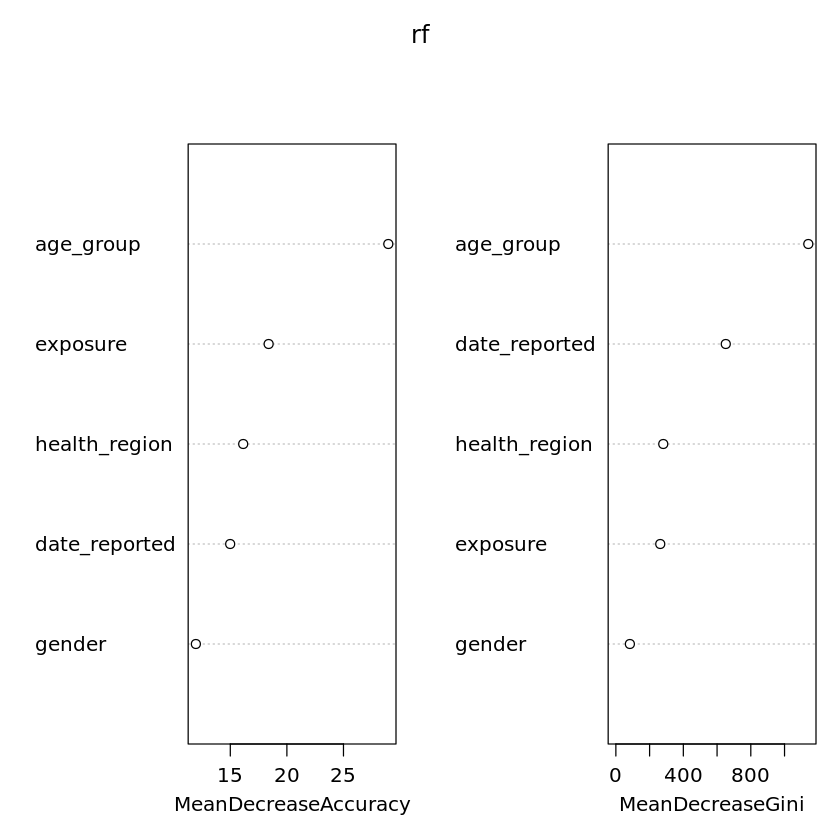

In [6]:
varImpPlot(rf)

## Example with permute and predict on the same dataset

In [7]:
full_data<-sdgm::oncovid 

voutcome<-"case_status"
# train a model with optimal hyperparameters
best_model<-sdgm::lgbm.bestmodel.bin(full_data, voutcome, tune=F)

# get baseline AUC
preds<-predict(best_model, full_data)
y_true<-full_data[,voutcome]
baseline<-sdgm::auc(preds, y_true)

predictors<- full_data %>% select(-all_of(voutcome)) %>% names

imp<-sapply(predictors, function(var)
{
    mean(sapply(seq(10), function(i) #10 iterations
    {
      full_data[,var] <- sample(full_data[,var]) #permuting, full data is chnaged here but since its in a loop it makes a copy of this and dosen't aftter future iterations.
      preds<-predict(best_model, full_data)
      y_true<-full_data[,voutcome]
      baseline-sdgm::auc(preds, y_true)
    }))
})

results<-data.frame(variables=predictors,importance=imp)
print(results[order(results$importance, decreasing=T),])

[1] "case_status"   "age_group"     "gender"        "date_reported"
[5] "exposure"      "health_region"
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038154 -> initscore=-3.227224
[LightGBM] [Info] Start training from score -3.227224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038552 -> initscore=-3.216421
[LightGBM] [Info] Start training from score -3.216421
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038141 -> initscore=-3.227584
[LightGBM] [Info] Start training from score -3.227584
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038030 -> initscore=-3.230599
[LightGBM] [Info] Start training from score -3.230599
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038703 -> initscore=-3.212366
[LightGBM] [Info] Start training from score -3.212366
                  variables  importance
age_group         age_group 0.322801590
date_reported date_reported 0.033328738
exposure           exposure 0.009972569
health_region health_region 0.009091229
gender               gende

## Variable importance on test dataset

In [13]:
full_data<-sdgm::oncovid #HEre in this code we are permuting the test dataset and running it through the model
voutcome<-"case_status"

idx<-splitTools::partition(full_data[,voutcome], p=c(train=0.7, test=0.3), type="stratified")
train_data <- full_data[idx$train,] 
test_data <- full_data[idx$test,]

# train an LGBM
best_model<-sdgm::lgbm.bestmodel.bin(train_data, voutcome, tune=F)

# get baseline AUC on test data
preds<-predict(best_model, test_data)
y_true<-test_data[,voutcome]
baseline<-sdgm::auc(preds, y_true)

predictors<- test_data %>% select(-all_of(voutcome)) %>% names

imp<-sapply(predictors, function(var) #permute and re-train the model.
{
    mean(sapply(seq(10), function(i)
    {
      test_data[,var] <- sample(test_data[,var])
      preds<-predict(best_model, test_data)
      y_true<-test_data[,voutcome]
      baseline-sdgm::auc(preds, y_true)
    }))
})

results<-data.frame(variables=predictors,importance=imp)
print(results[order(results$importance, decreasing=T),])

[1] "case_status"   "age_group"     "gender"        "date_reported"
[5] "exposure"      "health_region"
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038234 -> initscore=-3.225058
[LightGBM] [Info] Start training from score -3.225058
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.037645 -> initscore=-3.241190
[LightGBM] [Info] Start training from score -3.241190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038194 -> initscore=-3.226126
[LightGBM] [Info] Start training from score -3.226126
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038745 -> initscore=-3.211248
[LightGBM] [Info] Start training from score -3.211248
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038823 -> initscore=-3.209142
[LightGBM] [Info] Start training from score -3.209142
                  variables  importance
age_group         age_group 0.312778514
date_reported date_reported 0.021463207
exposure           exposure 0.007226238
gender               gender 0.002791197
health_region health_regio